# **Importing Modules and Libraries**

## Sumber dan Jenis Data

### Identifikasi Sumber Data
Data yang digunakan dalam proyek ini dikumpulkan dari repositori publik, khususnya dataset **'Obfuscated-MalMem2022'** yang tersedia di Kaggle. Dataset ini berfokus pada memori malware yang di-obfuscated dan dikumpulkan dari sistem nyata atau lingkungan simulasi yang mereplikasi skenario serangan malware.

### Jenis Data
Jenis data yang digunakan untuk deteksi ransomware dalam proyek ini adalah fitur numerik yang diekstraksi dari hasil forensik memori. Meskipun arsitektur Transformer seringkali diasosiasikan dengan data sekuensial seperti urutan panggilan API, dalam konteks ini, Transformer digunakan untuk memproses serangkaian fitur numerik yang merepresentasikan perilaku sistem dan karakteristik proses:

*   **Fitur Numerik/Statik**: Ini mencakup berbagai metrik dan statistik yang diekstraksi dari memori, seperti jumlah proses (`pslist.nproc`), jumlah thread rata-rata (`pslist.avg_threads`), jumlah DLL (`dlllist.ndlls`), jumlah handle (`handles.nhandles`), dan berbagai indikator aktivitas mencurigakan dari modul loader, injeksi malware (`malfind`), dan pemeriksaan psxview (`psxview`). Fitur-fitur ini, meskipun tidak secara langsung merupakan 'urutan panggilan API' mentah, merepresentasikan 'keadaan' atau 'perilaku' sistem yang dapat dianalisis secara sekuensial atau dalam hubungan kontekstual oleh model Transformer.

In [ ]:
%pip install transformers scikit-learn matplotlib pandas
%pip install seaborn
%pip install torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import re

from torch.cuda.amp import autocast, GradScaler


In [ ]:
import os
#os.environ['AMD_SERIALIZE_KERNEL'] ='3'
#os.environ['TORCH_USE_HIP_DSA'] ='1'
#os.environ['HIP_VISIBLE_DEVICES']='0'
#os.environ['PYTORCH_ROCM_ARCH'] = '"gfx1031"'
os.environ['HSA_OVERRIDE_GFX_VERSION'] ='10.3.0'

import torch

# Checking if ROCm is available
if torch.backends.mps.is_available():
    print("ROCm backend is available")

# This will list the ROCm-supported devices
if torch.cuda.is_available():
    print(f"Available AMD GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No ROCm-compatible GPU detected")

No ROCm-compatible GPU detected


# **Importing Datasets**

In [ ]:
import requests
import zipfile

file_name = 'obfuscated-malware-memory-2022-cic.zip' # Changed to .zip to reflect download
csv_file_name = 'Obfuscated-MalMem2022.csv'
download_url = 'https://www.kaggle.com/api/v1/datasets/download/luccagodoy/obfuscated-malware-memory-2022-cic'

# Check if the CSV file already exists
if not os.path.exists(csv_file_name):
    # Check if the zip file exists
    if not os.path.exists(file_name):
        print(f"{file_name} does not exist. Downloading now...")
        headers = {'User-Agent': 'Mozilla/5.0'} # Kaggle might require User-Agent
        response = requests.get(download_url, headers=headers, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        with open(file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    else:
        print(f"{file_name} already exists. Skipping download.")

    # Unzip the file if the CSV does not exist
    print("Unzipping the file...")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('.') # Extract to the current directory
    print("Unzipping complete.")
else:
    print(f"{csv_file_name} already exists. Skipping download and unzip.")

Obfuscated-MalMem2022.csv already exists. Skipping download and unzip.


In [ ]:
data = pd.read_csv('Obfuscated-MalMem2022.csv')


#**Data Cleaning**

In [ ]:
data.head(n=5)


,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58596 entries, 0 to 58595
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Category                                58596 non-null  object 
 1   pslist.nproc                            58596 non-null  int64  
 2   pslist.nppid                            58596 non-null  int64  
 3   pslist.avg_threads                      58596 non-null  float64
 4   pslist.nprocs64bit                      58596 non-null  int64  
 5   pslist.avg_handlers                     58596 non-null  float64
 6   dlllist.ndlls                           58596 non-null  int64  
 7   dlllist.avg_dlls_per_proc               58596 non-null  float64
 8   handles.nhandles                        58596 non-null  int64  
 9   handles.avg_handles_per_proc            58596 non-null  float64
 10  handles.nport                           58596 non-null  in

##Mengatasi missing value

In [ ]:
data.isnull().sum()


Category                                  0
pslist.nproc                              0
pslist.nppid                              0
pslist.avg_threads                        0
pslist.nprocs64bit                        0
pslist.avg_handlers                       0
dlllist.ndlls                             0
dlllist.avg_dlls_per_proc                 0
handles.nhandles                          0
handles.avg_handles_per_proc              0
handles.nport                             0
handles.nfile                             0
handles.nevent                            0
handles.ndesktop                          0
handles.nkey                              0
handles.nthread                           0
handles.ndirectory                        0
handles.nsemaphore                        0
handles.ntimer                            0
handles.nsection                          0
handles.nmutant                           0
ldrmodules.not_in_load                    0
ldrmodules.not_in_init          

In [ ]:
data.shape

(58596, 57)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(58596, 57)

##Memeriksa distribusi kategori

In [ ]:
data['Category'].value_counts()

Category
Benign                                                                                    29298
Ransomware-Pysa-5f3166fc81e2415abe55db02124934be66e02c8ac573bd3f3a0a6d8b73a7a7fc-3.raw        2
Ransomware-Pysa-5f3166fc81e2415abe55db02124934be66e02c8ac573bd3f3a0a6d8b73a7a7fc-5.raw        2
Ransomware-Pysa-5f3166fc81e2415abe55db02124934be66e02c8ac573bd3f3a0a6d8b73a7a7fc-6.raw        2
Ransomware-Pysa-5f3166fc81e2415abe55db02124934be66e02c8ac573bd3f3a0a6d8b73a7a7fc-7.raw        2
                                                                                          ...  
Ransomware-Ako-0a1e176eded8c1801fcd09e8cf9f796c326bc7e9b51531fb40a32f5214d6ba76-2.raw         1
Ransomware-Ako-0a1e176eded8c1801fcd09e8cf9f796c326bc7e9b51531fb40a32f5214d6ba76-3.raw         1
Ransomware-Ako-0a1e176eded8c1801fcd09e8cf9f796c326bc7e9b51531fb40a32f5214d6ba76-4.raw         1
Ransomware-Ako-0a1e176eded8c1801fcd09e8cf9f796c326bc7e9b51531fb40a32f5214d6ba76-5.raw         1
Ransomware-Ako-00a2c6bab1e53f67

##Merubah Kategori

Dua kolom ditambahkan seperti *Sub_Category* dan *Main_Category* agar bisa diperjelas

In [ ]:
def extract_category(value):
    match = re.match(r'^[^-]+-[^-]+', value)
    if match:
        return match.group()
    return value

In [ ]:
data['Cleaned_Category'] = data['Category'].apply(extract_category)

In [ ]:
data['Cleaned_Category'].value_counts()

Cleaned_Category
Benign                  29298
Spyware-Transponder      2410
Spyware-Gator            2200
Ransomware-Shade         2128
Spyware-CWS              2000
Trojan-Scar              2000
Spyware-180solutions     2000
Ransomware-Ako           2000
Trojan-Refroso           2000
Ransomware-Conti         1988
Trojan-Emotet            1967
Ransomware-Maze          1958
Trojan-Zeus              1950
Ransomware-Pysa          1717
Trojan-Reconyc           1570
Spyware-TIBS             1410
Name: count, dtype: int64

In [ ]:
data['Main_Category'] = data['Cleaned_Category'].apply(lambda x: x.split('-')[0])

In [ ]:
data['Main_Category'].value_counts()

Main_Category
Benign        29298
Spyware       10020
Ransomware     9791
Trojan         9487
Name: count, dtype: int64

In [ ]:
data = data[~data['Main_Category'].isin(['Spyware', 'Trojan'])]
data['Main_Category'].value_counts()

Main_Category
Benign        29298
Ransomware     9791
Name: count, dtype: int64

In [ ]:
data['Sub_Category'] = data['Cleaned_Category'].apply(lambda x: x.split('-')[1] if '-' in x else x)

In [ ]:
data['Sub_Category'].value_counts()

Sub_Category
Benign    29298
Shade      2128
Ako        2000
Conti      1988
Maze       1958
Pysa       1717
Name: count, dtype: int64

In [ ]:
data.drop(columns="Category",inplace=True)
data.drop(columns="Class", inplace=True)
data.drop(columns="Cleaned_Category",inplace=True)
data.drop(columns="Main_Category",inplace=True)

In [ ]:
data.to_csv('data.csv')

##**Merubah data menjadi numerik**

In [ ]:
# Identifying different types of columns
nominal_names = data.select_dtypes(include=['object']).columns
integer_names = data.select_dtypes(include=['int', 'int64']).columns
binary_names = []
float_names = data.select_dtypes(include=['float', 'float64']).columns

In [ ]:
# Identifying binary columns (with only two unique values, e.g., 0 and 1)
for c in data.columns:
    if data[c].nunique() == 2 and data[c].dtype in ['int64', 'int', 'float64']:
        binary_names.append(c)

# Converting integer columns to numeric
for c in integer_names:
    data[c] = pd.to_numeric(data[c])

# Converting binary columns to numeric (optional step if already int/float)
for c in binary_names:
    data[c] = pd.to_numeric(data[c])

# Converting float columns to numeric
for c in float_names:
    data[c] = pd.to_numeric(data[c])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39089 entries, 0 to 58595
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   pslist.nproc                            39089 non-null  int64  
 1   pslist.nppid                            39089 non-null  int64  
 2   pslist.avg_threads                      39089 non-null  float64
 3   pslist.nprocs64bit                      39089 non-null  int64  
 4   pslist.avg_handlers                     39089 non-null  float64
 5   dlllist.ndlls                           39089 non-null  int64  
 6   dlllist.avg_dlls_per_proc               39089 non-null  float64
 7   handles.nhandles                        39089 non-null  int64  
 8   handles.avg_handles_per_proc            39089 non-null  float64
 9   handles.nport                           39089 non-null  int64  
 10  handles.nfile                           39089 non-null  int64  

# **Data Visualization**

##**Sub-Class Visualization**

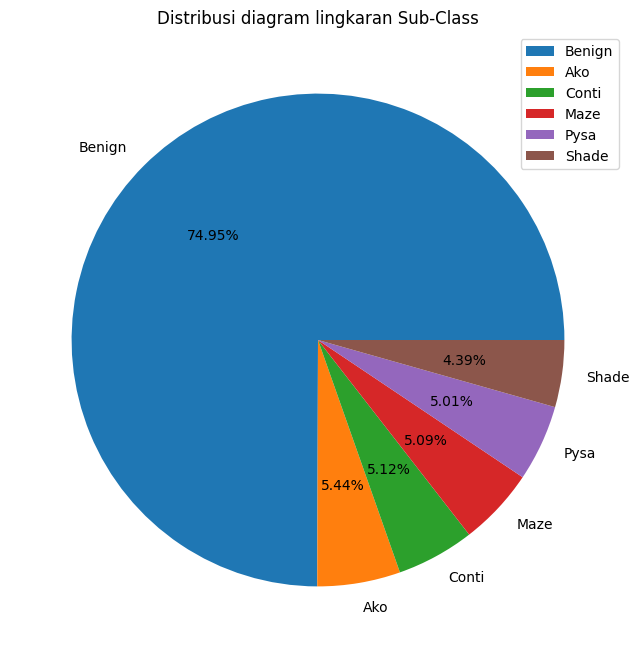

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(data.Sub_Category.value_counts(),labels=data.Sub_Category.unique(),autopct='%0.2f%%')
plt.title('Distribusi diagram lingkaran Sub-Class')
plt.legend(loc='best')
plt.show()

#**Label Encoding**

In [ ]:
bin_label = pd.DataFrame(data.Sub_Category)

In [ ]:
bin_data = data.copy()

In [ ]:
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['Sub_Category'] = enc_label

In [ ]:
le1.classes_

array(['Ako', 'Benign', 'Conti', 'Maze', 'Pysa', 'Shade'], dtype=object)

In [ ]:
np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

# **Correlation between features of dataset**

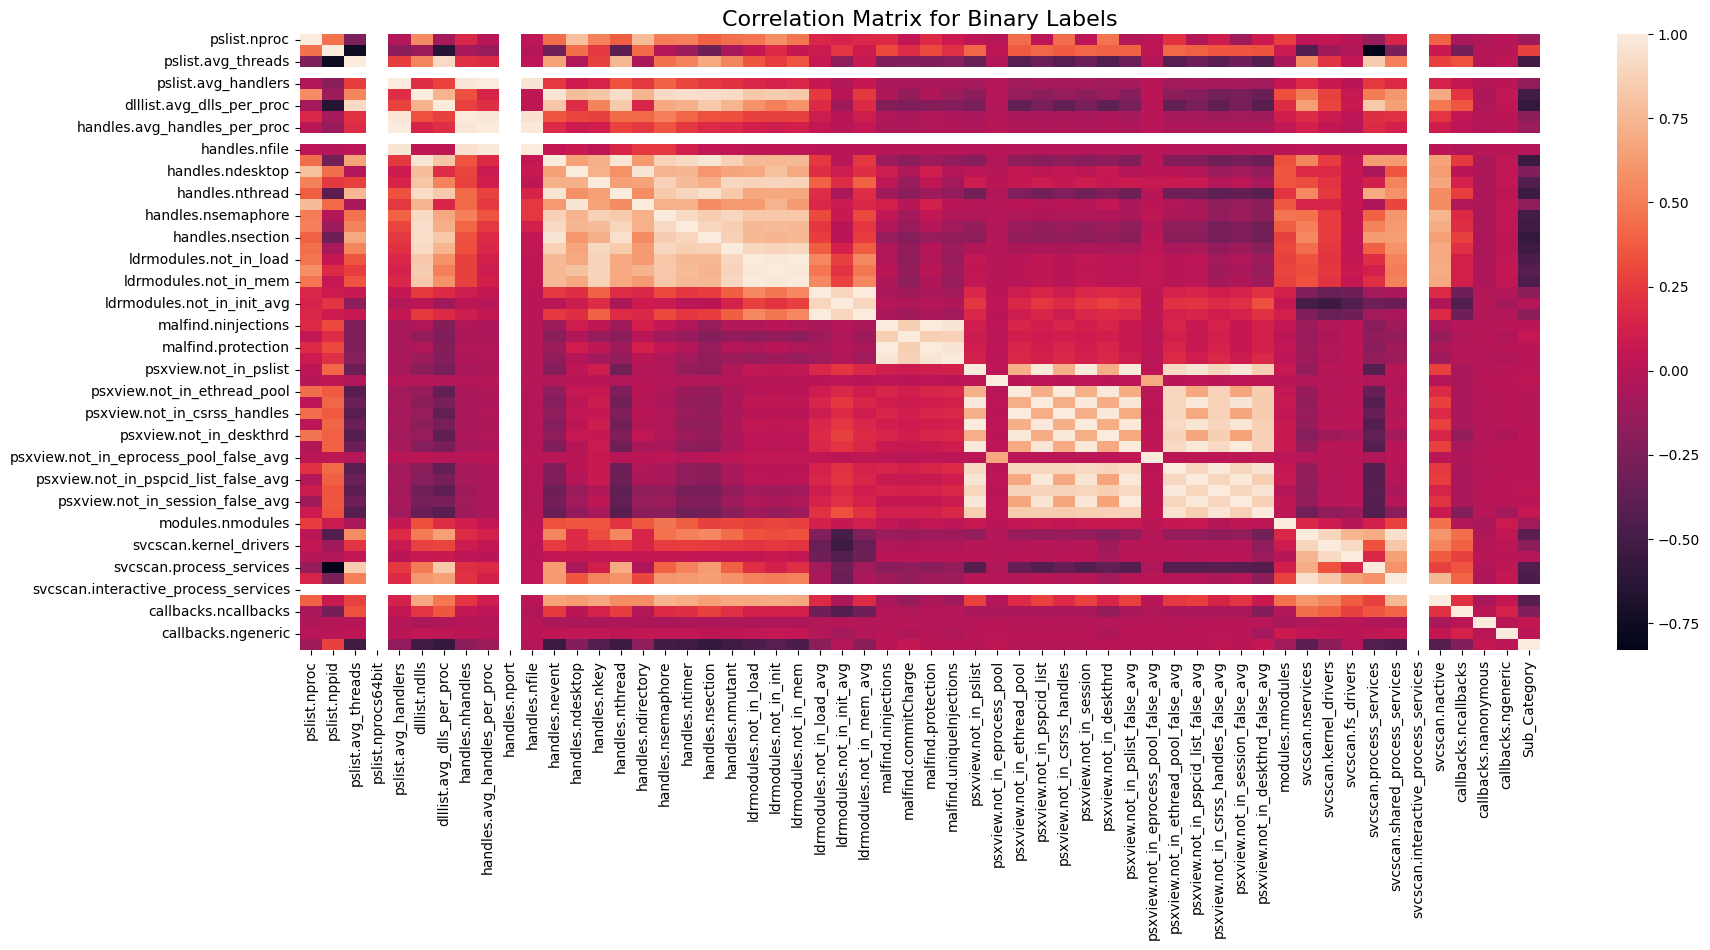

In [ ]:
plt.figure(figsize=(20,8))
corr_bin = bin_data.corr()
sns.heatmap(corr_bin,vmax=1.0,annot=False)
plt.title('Correlation Matrix for Binary Labels',fontsize=16)
plt.show()

# **Feature Selection**

In [ ]:
corr_ybin = abs(corr_bin['Sub_Category'])
highest_corr_bin = corr_ybin[corr_ybin >= 0.20]
highest_corr_bin.sort_values(ascending=True)

handles.ndesktop                   0.221005
callbacks.ncallbacks               0.228917
pslist.nppid                       0.274871
svcscan.nservices                  0.389798
ldrmodules.not_in_init             0.414736
svcscan.nactive                    0.418488
handles.nkey                       0.438590
svcscan.process_services           0.440829
svcscan.shared_process_services    0.459790
ldrmodules.not_in_mem              0.461366
ldrmodules.not_in_load             0.461412
handles.nsemaphore                 0.504964
dlllist.ndlls                      0.513934
pslist.avg_threads                 0.514737
handles.ntimer                     0.526619
handles.nmutant                    0.530116
handles.nthread                    0.543016
handles.nevent                     0.549885
dlllist.avg_dlls_per_proc          0.576765
handles.nsection                   0.579873
Sub_Category                       1.000000
Name: Sub_Category, dtype: float64

In [ ]:
bin_cols = highest_corr_bin.index
bin_cols

Index(['pslist.nppid', 'pslist.avg_threads', 'dlllist.ndlls',
       'dlllist.avg_dlls_per_proc', 'handles.nevent', 'handles.ndesktop',
       'handles.nkey', 'handles.nthread', 'handles.nsemaphore',
       'handles.ntimer', 'handles.nsection', 'handles.nmutant',
       'ldrmodules.not_in_load', 'ldrmodules.not_in_init',
       'ldrmodules.not_in_mem', 'svcscan.nservices',
       'svcscan.process_services', 'svcscan.shared_process_services',
       'svcscan.nactive', 'callbacks.ncallbacks', 'Sub_Category'],
      dtype='object')

In [ ]:
bin_data = bin_data[bin_cols].copy()
bin_data

,pslist.nppid,pslist.avg_threads,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nevent,handles.ndesktop,handles.nkey,handles.nthread,handles.nsemaphore,handles.ntimer,...,handles.nmutant,ldrmodules.not_in_load,ldrmodules.not_in_init,ldrmodules.not_in_mem,svcscan.nservices,svcscan.process_services,svcscan.shared_process_services,svcscan.nactive,callbacks.ncallbacks,Sub_Category
0,17,10.555556,1694,38.500000,3161,46,716,887,671,125,...,257,53,95,53,389,24,116,121,87,1
1,19,11.531915,2074,44.127660,3761,51,1011,1030,766,148,...,394,77,123,77,392,24,118,122,87,1
2,14,14.725000,1932,48.300000,3996,45,784,1241,645,138,...,338,51,89,51,395,27,118,120,88,1
3,13,13.500000,1445,45.156250,2961,36,654,792,567,127,...,242,31,62,31,395,27,118,120,88,1
4,16,11.452381,2067,49.214286,3834,45,1252,942,825,135,...,429,102,143,102,392,24,118,124,87,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58591,15,10.108108,1453,39.270270,2819,40,668,664,596,113,...,230,43,79,43,389,24,116,120,86,5
58592,14,9.945946,1347,36.405405,2394,39,555,624,482,102,...,203,43,79,43,389,24,116,116,88,5
58593,15,9.842105,1448,38.105263,2816,40,673,661,596,113,...,230,43,79,43,389,24,116,120,88,5
58594,15,10.243243,1452,39.243243,2819,40,668,667,596,113,...,230,43,79,43,389,24,116,120,87,5


In [ ]:
#value_map = {
#    0: 'Benign',
#    1: 'Ransomware',
#    2: 'Spyware',
#    3: 'Trojan'
#}

#bin_data['Main_Category'] = bin_data['Main_Category'].map(value_map)

In [ ]:
bin_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39089 entries, 0 to 58595
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   pslist.nppid                     39089 non-null  int64  
 1   pslist.avg_threads               39089 non-null  float64
 2   dlllist.ndlls                    39089 non-null  int64  
 3   dlllist.avg_dlls_per_proc        39089 non-null  float64
 4   handles.nevent                   39089 non-null  int64  
 5   handles.ndesktop                 39089 non-null  int64  
 6   handles.nkey                     39089 non-null  int64  
 7   handles.nthread                  39089 non-null  int64  
 8   handles.nsemaphore               39089 non-null  int64  
 9   handles.ntimer                   39089 non-null  int64  
 10  handles.nsection                 39089 non-null  int64  
 11  handles.nmutant                  39089 non-null  int64  
 12  ldrmodules.not_in_load 

# **Data Normalization**


In [ ]:
X_n = bin_data.drop(columns=['Sub_Category'])
y_n = bin_data['Sub_Category']

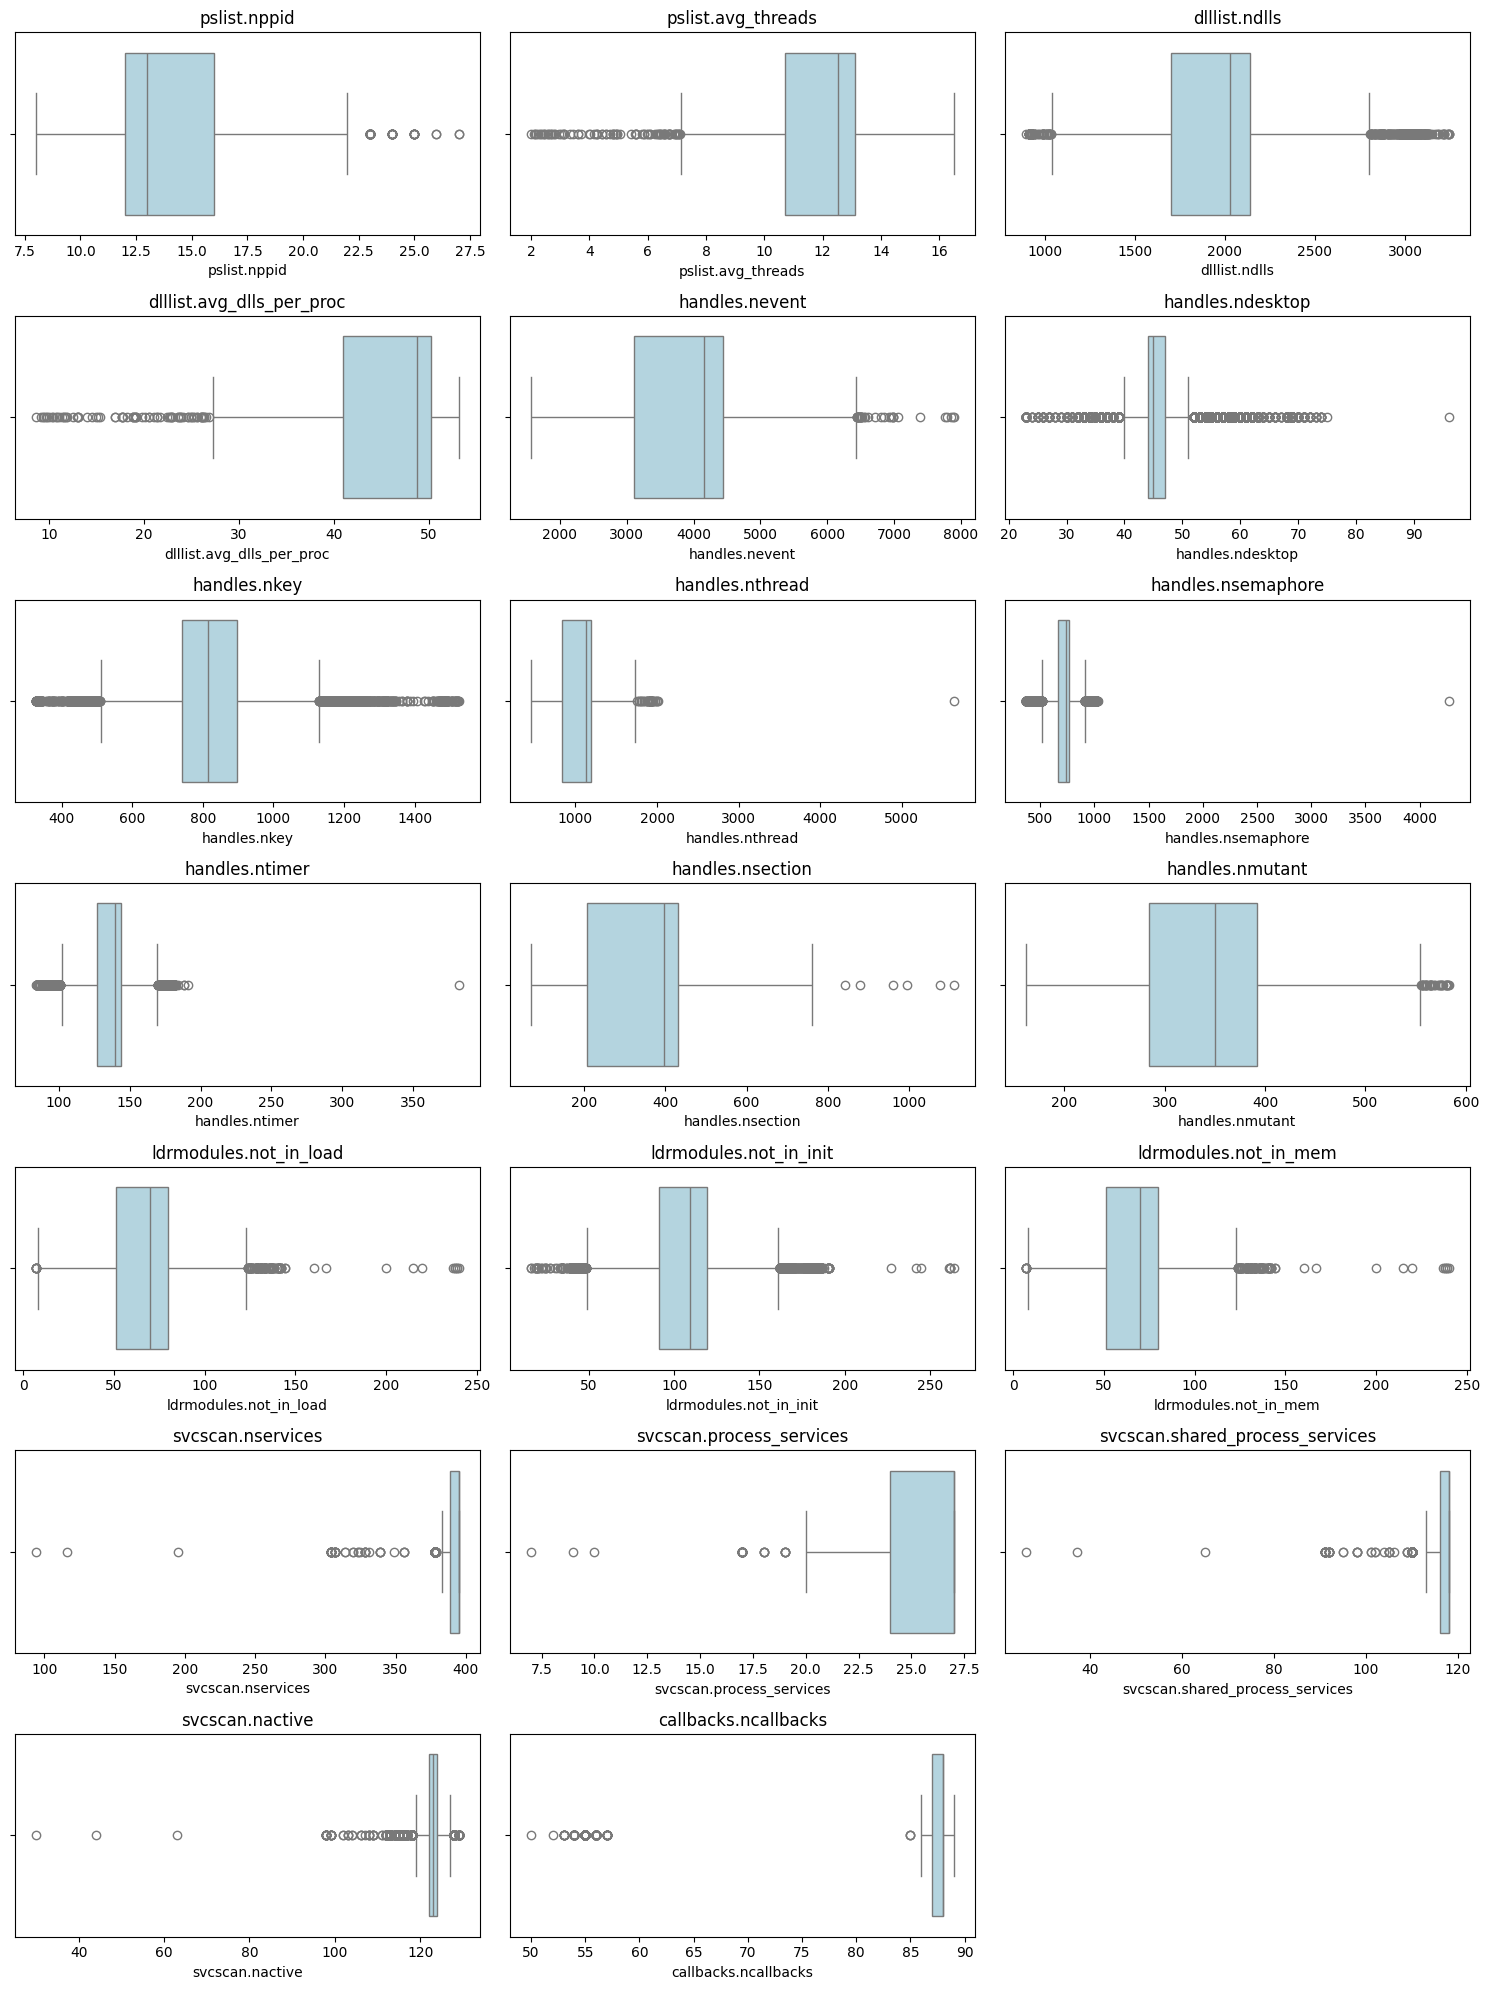

In [ ]:
# Using boxplots to check for outliers in each feature
plt.figure(figsize=(15, 20))
num_features = X_n.columns

# Creating subplots for each feature to visualize outliers
for i, feature in enumerate(num_features):
    plt.subplot(7, 3, i + 1)  # Creating subplots in a grid of 7 rows and 3 columns
    sns.boxplot(x=X_n[feature], color='lightblue')
    plt.title(feature)
    plt.tight_layout()

plt.show()

In [ ]:
import numpy as np

# Calculate the first and third quartiles
Q1 = np.percentile(X_n, 25, axis=0)
Q3 = np.percentile(X_n, 75, axis=0)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a mask to filter out rows where all features are within the bounds
non_outlier_mask = ((X_n >= lower_bound) & (X_n <= upper_bound)).all(axis=1)

# Filter the dataset
X_no_outliers = X_n[non_outlier_mask]

# X_no_outliers = X_n[non_outlier_mask]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_no_outliers)

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_n.columns)

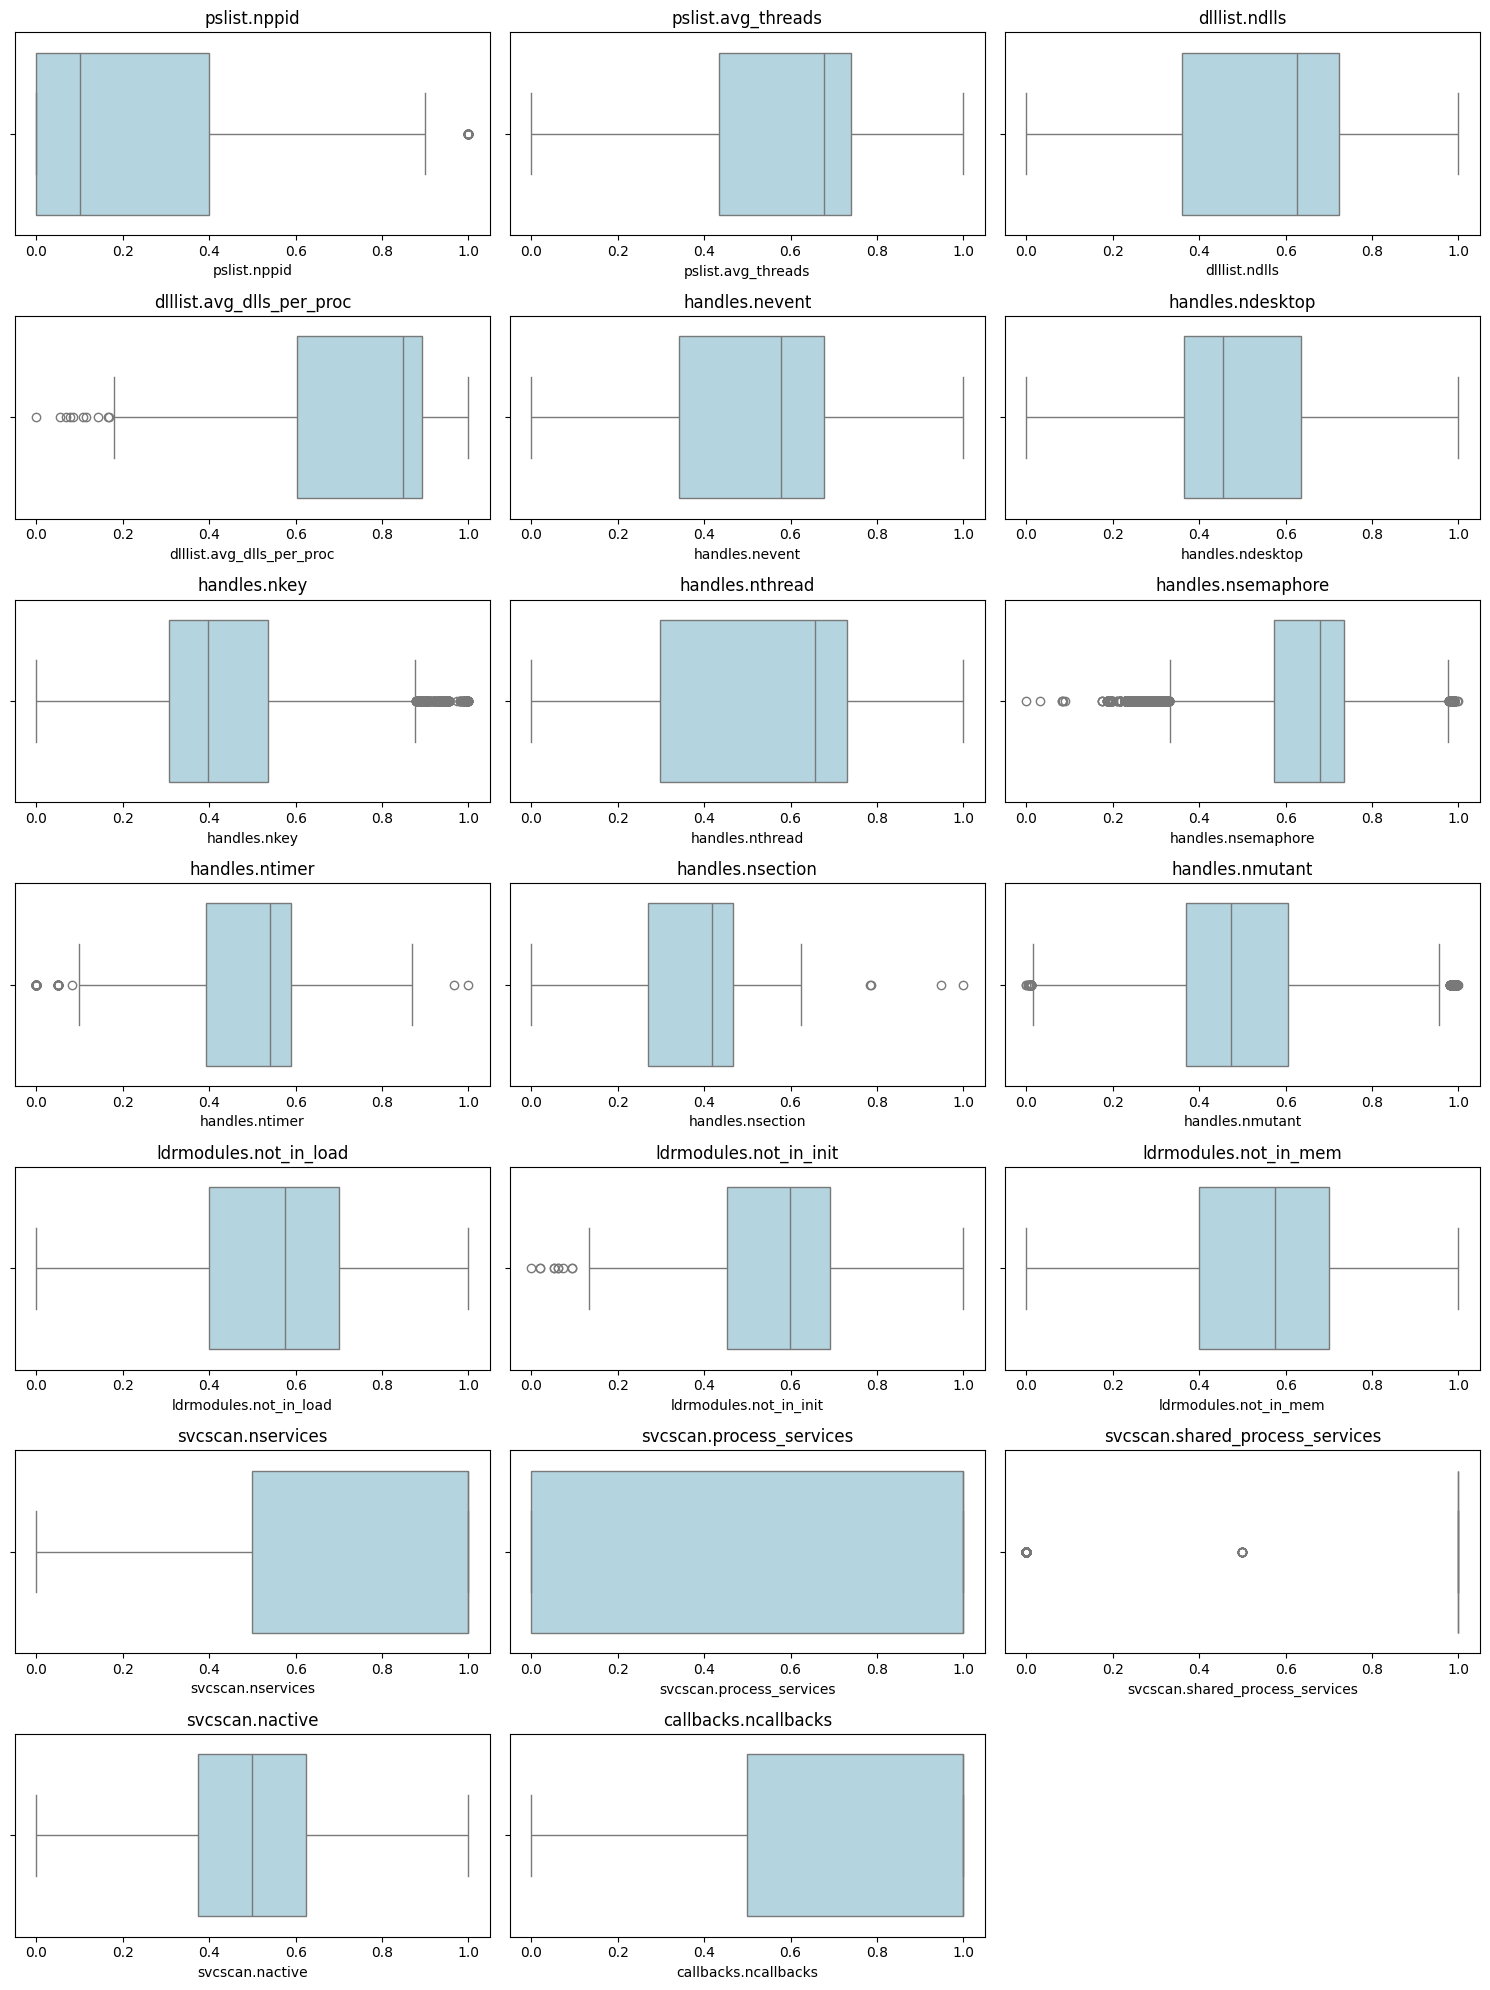

In [ ]:
# Using boxplots to check for outliers in each feature
plt.figure(figsize=(15, 20))
num_features_s = X_scaled_df.columns

# Creating subplots for each feature to visualize outliers
for i, feature in enumerate(num_features_s):
    plt.subplot(7, 3, i + 1)  # Creating subplots in a grid of 7 rows and 3 columns
    sns.boxplot(x=X_scaled_df[feature], color='lightblue')
    plt.title(feature)
    plt.tight_layout()

plt.show()

In [ ]:
combined_data = pd.concat([X_scaled_df, y_n.reset_index(drop=True)], axis=1)

In [ ]:
# Total number of rows in the DataFrame
total_rows = len(combined_data)

# Calculate percentage of null values
null_percentage = (combined_data.isnull().sum() / total_rows) * 100

# Display the percentage of null values for each column
print(null_percentage)

pslist.nppid                       15.324004
pslist.avg_threads                 15.324004
dlllist.ndlls                      15.324004
dlllist.avg_dlls_per_proc          15.324004
handles.nevent                     15.324004
handles.ndesktop                   15.324004
handles.nkey                       15.324004
handles.nthread                    15.324004
handles.nsemaphore                 15.324004
handles.ntimer                     15.324004
handles.nsection                   15.324004
handles.nmutant                    15.324004
ldrmodules.not_in_load             15.324004
ldrmodules.not_in_init             15.324004
ldrmodules.not_in_mem              15.324004
svcscan.nservices                  15.324004
svcscan.process_services           15.324004
svcscan.shared_process_services    15.324004
svcscan.nactive                    15.324004
callbacks.ncallbacks               15.324004
Sub_Category                        0.000000
dtype: float64


In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
combined_data.iloc[:, :] = imputer.fit_transform(combined_data)

In [ ]:
# Total number of rows in the DataFrame
total_rows = len(combined_data)

# Calculate percentage of null values
null_percentage = (combined_data.isnull().sum() / total_rows) * 100

# Display the percentage of null values for each column
print(null_percentage)

pslist.nppid                       0.0
pslist.avg_threads                 0.0
dlllist.ndlls                      0.0
dlllist.avg_dlls_per_proc          0.0
handles.nevent                     0.0
handles.ndesktop                   0.0
handles.nkey                       0.0
handles.nthread                    0.0
handles.nsemaphore                 0.0
handles.ntimer                     0.0
handles.nsection                   0.0
handles.nmutant                    0.0
ldrmodules.not_in_load             0.0
ldrmodules.not_in_init             0.0
ldrmodules.not_in_mem              0.0
svcscan.nservices                  0.0
svcscan.process_services           0.0
svcscan.shared_process_services    0.0
svcscan.nactive                    0.0
callbacks.ncallbacks               0.0
Sub_Category                       0.0
dtype: float64


In [ ]:
combined_data['Sub_Category'].value_counts()

Sub_Category
1    29298
5     2128
0     2000
2     1988
3     1958
4     1717
Name: count, dtype: int64

In [ ]:
combined_data.to_csv('bin_data_scaled.csv', index=False)

# **Data Balancing**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
data_bin = pd.read_csv("bin_data_scaled.csv")

In [ ]:
# Assuming data_bin is your DataFrame with features and 'Sub_Category' as the target column
# Separate features (X) and target (y)
X_bin = data_bin.drop(columns=['Sub_Category']).values
y_bin = data_bin['Sub_Category'].values

# Split central and client data
X_central, X_clients, y_central, y_clients = train_test_split(X_bin, y_bin, test_size=0.7, random_state=55)

# Shuffle the indices
indices = np.arange(len(X_clients))
np.random.shuffle(indices)

# Split the shuffled indices into 3 clients
client_splits = np.array_split(indices, 3)

# Create client data based on the new splits
client_data = [(X_clients[split_indices], y_clients[split_indices]) for split_indices in client_splits]

# Export client data to CSV files with the correct feature names
feature_columns = data_bin.drop(columns=['Sub_Category']).columns

for i, (X_client, y_client) in enumerate(client_data, start=1):
    df_client = pd.DataFrame(X_client, columns=feature_columns)  # Use actual feature names
    df_client['Sub_Category'] = y_client
    df_client.to_csv(f"client_data_{i}.csv", index=False)


In [ ]:
# Visualize the distribution before SMOTE
def visualize_distribution(y_data, title):
    counter = Counter(y_data)
    print(counter.keys(),counter.values())
    plt.bar(counter.keys(), counter.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Apply SMOTE to each client and visualize the distribution after SMOTE
smote = SMOTE(random_state=120)

dict_keys([np.int64(2), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(0)]) dict_values([576, 8782, 616, 519, 634, 599])


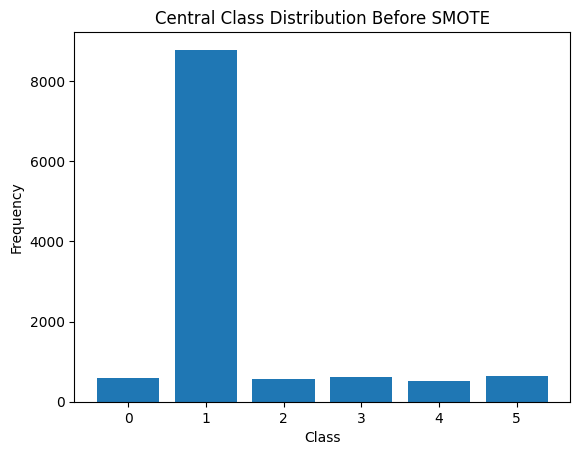

In [ ]:
# Visualize distribution for central data before SMOTE
visualize_distribution(y_central, title='Central Class Distribution Before SMOTE')

dict_keys([np.int64(2), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(0)]) dict_values([8782, 8782, 8782, 8782, 8782, 8782])


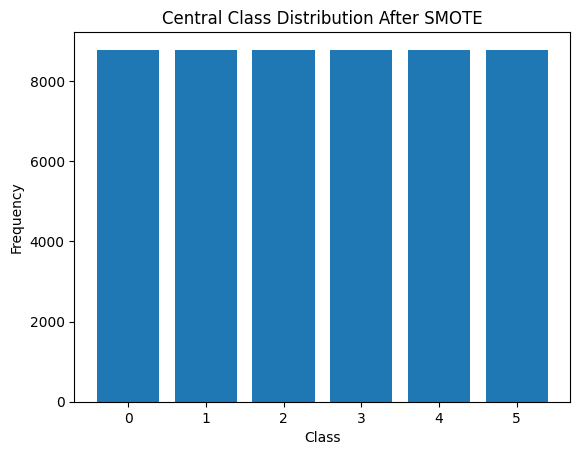

In [ ]:
# Apply SMOTE to central data and visualize the distribution after SMOTE
X_central_resampled, y_central_resampled = smote.fit_resample(X_central, y_central)
visualize_distribution(y_central_resampled, title='Central Class Distribution After SMOTE')

dict_keys([np.int64(1), np.int64(5), np.int64(3), np.int64(0), np.int64(4), np.int64(2)]) dict_values([6846, 504, 471, 453, 383, 464])


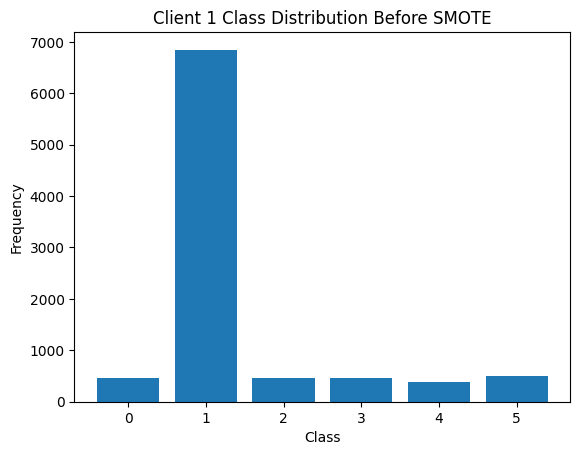

dict_keys([np.int64(1), np.int64(2), np.int64(5), np.int64(3), np.int64(4), np.int64(0)]) dict_values([6811, 485, 476, 454, 404, 491])


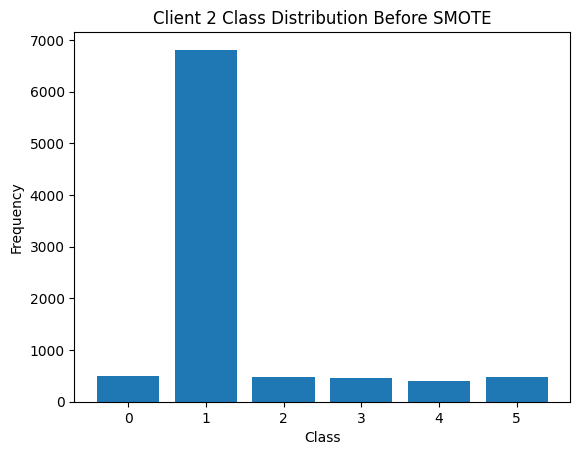

dict_keys([np.int64(1), np.int64(5), np.int64(0), np.int64(3), np.int64(4), np.int64(2)]) dict_values([6859, 514, 457, 417, 411, 463])


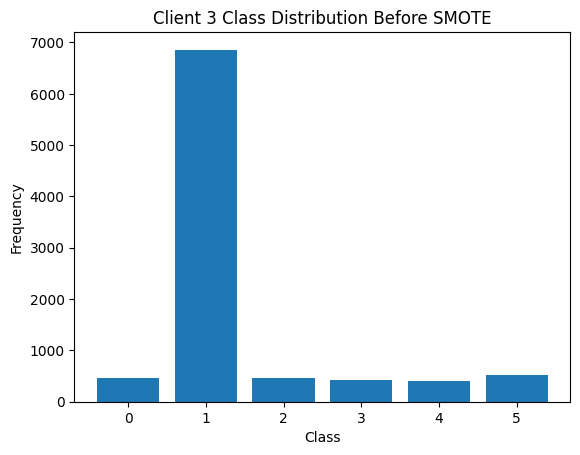

In [ ]:
# Visualize distribution for each client before SMOTE
for i, (X_client, y_client) in enumerate(client_data):
    visualize_distribution(y_client, title=f'Client {i+1} Class Distribution Before SMOTE')

dict_keys([np.int64(1), np.int64(5), np.int64(3), np.int64(0), np.int64(4), np.int64(2)]) dict_values([6846, 6846, 6846, 6846, 6846, 6846])


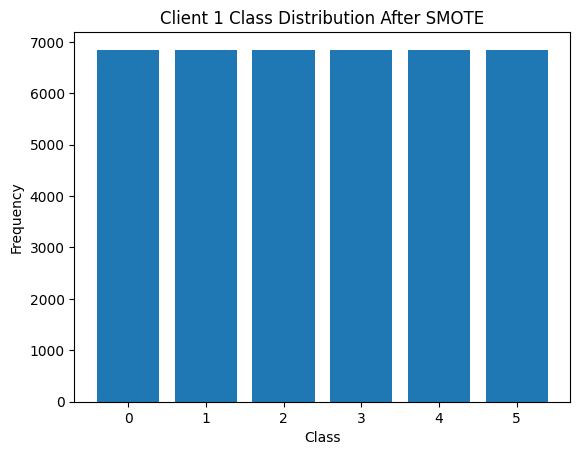

dict_keys([np.int64(1), np.int64(2), np.int64(5), np.int64(3), np.int64(4), np.int64(0)]) dict_values([6811, 6811, 6811, 6811, 6811, 6811])


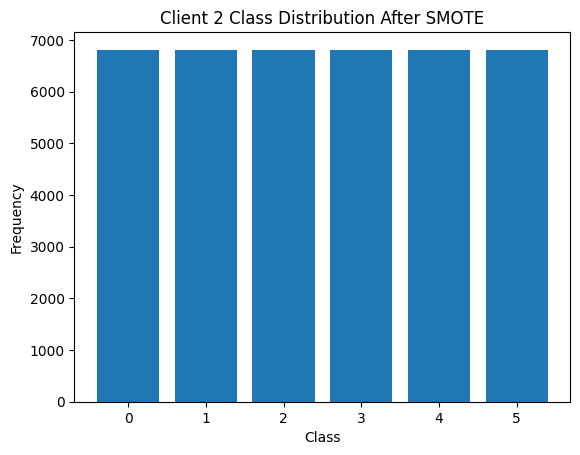

dict_keys([np.int64(1), np.int64(5), np.int64(0), np.int64(3), np.int64(4), np.int64(2)]) dict_values([6859, 6859, 6859, 6859, 6859, 6859])


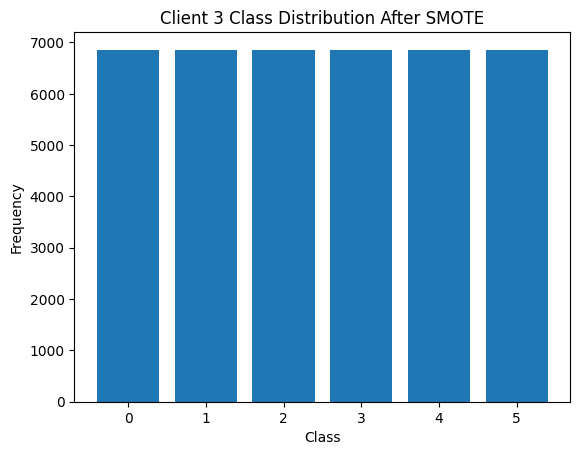

In [ ]:
client_data_smoted = []
for i, (X_client, y_client) in enumerate(client_data):
    X_client_resampled, y_client_resampled = smote.fit_resample(X_client, y_client)
    client_data_smoted.append((X_client_resampled, y_client_resampled))
    visualize_distribution(y_client_resampled, title=f'Client {i+1} Class Distribution After SMOTE')

# Further split client data into 5 clients
client_splits_smoted = np.array_split(np.arange(len(X_client_resampled)), 3)

# **Training setup**

In [ ]:
print("Mengambil informasi CPU...")
!lscpu | grep 'Model name'
!lscpu | grep 'Architecture'
!lscpu | grep 'CPU(s):'
!lscpu | grep 'Thread(s) per core:'

Mengambil informasi CPU...


'lscpu' is not recognized as an internal or external command,
operable program or batch file.
'lscpu' is not recognized as an internal or external command,
operable program or batch file.
'lscpu' is not recognized as an internal or external command,
operable program or batch file.
'lscpu' is not recognized as an internal or external command,
operable program or batch file.


**NOTE** \\
Penggunaan Variable untuk Balance dan Imbalance sebagai berikut:
- X_central: Imbalance (untuk Central sebelum SMOTE)
- X_clients: Imbalance (untuk Client sebelum SMOTE)
- X_central_resampled: Balanced (untuk Central setelah SMOTE)
- X_client_resampled: Balanced (untuk masing-masing Client setelah SMOTE)
- y_central: Imbalance (untuk Central sebelum SMOTE)
- y_clients: Imbalance (untuk Client sebelum SMOTE)
- y_central_resampled: Balanced (untuk Central setelah SMOTE)
- y_client_resampled: Balanced (untuk masing-masing Client setelah SMOTE)

In [ ]:
folder_name = 'Imbalanced'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"{folder_name} already exists. Skipping Folder Creation.")

Imbalanced already exists. Skipping Folder Creation.


In [ ]:
import torch
import math
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
)
from torch.utils.data import DataLoader, Subset, TensorDataset, random_split
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau# Import necessary library
from sklearn.model_selection import train_test_split
import itertools

In [ ]:
central_dataset = TensorDataset(
    torch.tensor(X_central, dtype=torch.float32), torch.tensor(y_central, dtype=torch.long)
)
client_datasets = [
    TensorDataset(
        torch.tensor(X_clients[indices], dtype=torch.float32),
        torch.tensor(y_clients[indices], dtype=torch.long),
    )
    for indices in client_splits
]

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU is available and being used" if torch.cuda.is_available() else "Using CPU due to lack of GPU")

Using CPU due to lack of GPU


# **TabTrans imba**

Jumlah sampel Benign: 29298
Jumlah sampel Sub_Category lainnya: 9791
Total sampel: 39089
Proporsi Benign: 74.95%
Proporsi Sub_Category lainnya: 25.05%


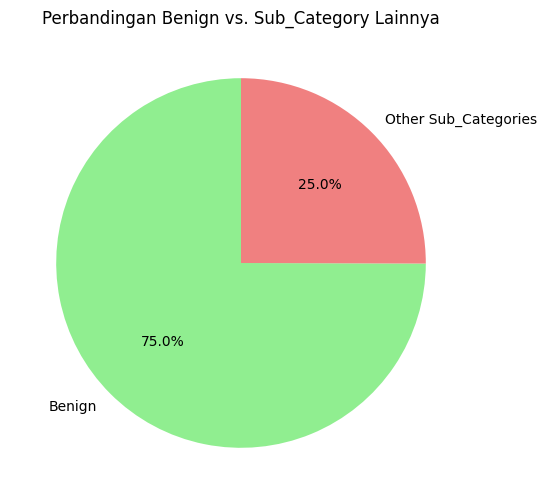

In [ ]:
sub_category_counts = bin_data['Sub_Category'].value_counts()

# 'Benign' is encoded as 1 based on le1.classes_ output
benign_count = sub_category_counts.get(1, 0)
other_categories_count = sub_category_counts.drop(1, errors='ignore').sum()

total_samples = benign_count + other_categories_count

if total_samples > 0:
    benign_proportion = benign_count / total_samples
    other_proportion = other_categories_count / total_samples

    print(f"Jumlah sampel Benign: {benign_count}")
    print(f"Jumlah sampel Sub_Category lainnya: {other_categories_count}")
    print(f"Total sampel: {total_samples}")
    print(f"Proporsi Benign: {benign_proportion:.2%}")
    print(f"Proporsi Sub_Category lainnya: {other_proportion:.2%}")

    # Optional: Visualize the proportion
    plt.figure(figsize=(6, 6))
    plt.pie([benign_count, other_categories_count], labels=['Benign', 'Other Sub_Categories'], autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
    plt.title('Perbandingan Benign vs. Sub_Category Lainnya')
    plt.show()
else:
    print("Tidak ada data untuk dihitung.")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13340\1058735330.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sub_Category', data=bin_data, palette='viridis')


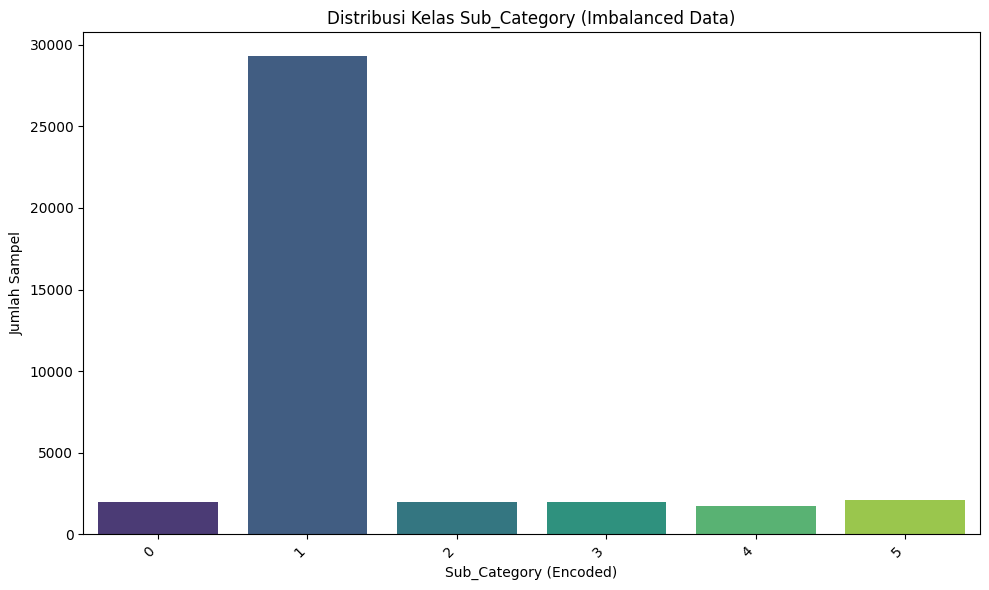

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import preprocessing

# Recreate data and bin_data from the notebook's processed state
# This assumes the original 'data' DataFrame has been loaded and initial cleaning (category extraction, filtering) performed.
# Since the notebook state shows these operations were executed, we can proceed from there.

# Make a copy of the 'data' DataFrame (which is already filtered for Benign/Ransomware and has 'Sub_Category' string column)
bin_data = data.copy()

# Re-apply Label Encoding for 'Sub_Category'
le1 = preprocessing.LabelEncoder()
bin_data['Sub_Category'] = le1.fit_transform(bin_data['Sub_Category'])

plt.figure(figsize=(10, 6))
sns.countplot(x='Sub_Category', data=bin_data, palette='viridis')
plt.title('Distribusi Kelas Sub_Category (Imbalanced Data)')
plt.xlabel('Sub_Category (Encoded)')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Plot di atas menunjukkan distribusi kelas `Sub_Category` sebelum balancing. Kita bisa melihat bahwa kelas `1` (Benign) memiliki jumlah sampel yang jauh lebih tinggi dibandingkan dengan kelas lainnya, mengonfirmasi kondisi data yang imbalanced.

In [ ]:
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, factor=5):
        super(ProbSparseSelfAttention, self).__init__()
        self.n_heads = n_heads
        self.factor = factor
        self.scale = 1 / math.sqrt(d_model // n_heads)
        self.dropout = nn.Dropout(dropout)
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, L, D = x.size()
        H = self.n_heads
        qkv = (
            self.qkv_proj(x)
            .reshape(B, L, 3, H, D // H)
            .permute(2, 0, 3, 1, 4)
        )  # (3, B, H, L, D_head)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each is (B, H, L, D_head)
        scores = torch.einsum("bhid,bhjd->bhij", q, k) * self.scale  # (B, H, L, L)
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.einsum("bhij,bhjd->bhid", attn, v)  # (B, H, L, D_head)
        out = out.transpose(1, 2).reshape(B, L, D)
        out = self.out_proj(out)
        return out

class InformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, factor=5):
        super(InformerEncoderLayer, self).__init__()
        self.self_attn = ProbSparseSelfAttention(
            d_model, n_heads, dropout=dropout, factor=factor
        )
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src):
        # Self-attention
        src2 = self.self_attn(src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        # Feed-forward network
        src2 = self.ffn(src)
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src

class InformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(InformerEncoder, self).__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])

    def forward(self, src):
        for layer in self.layers:
            src = layer(src)
        return src

class TabTransformer(nn.Module):
    def __init__(self, num_continuous, d_model, d_ff, num_layers, n_heads, output_dim, dropout=0.1, factor=5, mlp_hidden_mults=(4, 2), mlp_act=nn.ReLU()):
        super(TabTransformer, self).__init__()
        self.num_continuous = num_continuous
        self.dim = d_model
        self.depth = num_layers
        self.heads = n_heads

        # Continuous feature embedding
        self.cont_linear = nn.Linear(num_continuous, d_model)

        # Positional embedding
        self.position_embedding = nn.Parameter(torch.zeros(1, num_continuous, d_model))

        # Informer encoder layers
        encoder_layer = InformerEncoderLayer(d_model, n_heads, d_ff, dropout=dropout, factor=factor)
        self.transformer = InformerEncoder(encoder_layer, num_layers)

        # MLP layers
        mlp_input_dim = d_model * num_continuous
        hidden_dims = [int(mlp_input_dim * mult) for mult in mlp_hidden_mults]
        all_dims = [mlp_input_dim] + hidden_dims + [output_dim]
        layers = []
        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:
                layers.append(mlp_act)
                layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x_cont):
        # Continuous feature embedding and positional encoding
        x = self.cont_linear(x_cont).unsqueeze(1) + self.position_embedding[:, :self.num_continuous, :]

        # Informer encoding
        x = self.transformer(x).reshape(x_cont.size(0), -1)

        # Feed-forward layers
        out = self.mlp(x)
        return out

In [ ]:
# Define hyperparameters
num_continuous = X_central.shape[1]

dim = 256
depth = 4 #target 4
heads = 8 #target 8
attn_dropout = 0.3
ff_dropout = 0.1
mlp_hidden_mults = (4, 2)
mlp_act = nn.GELU()
output_dim = len(np.unique(y_bin))
num_epochs = 10
clients = 3
num_rounds = 3
k_folds = 5
batch_size = 32 #targeted 32

# try to solve OOM
scaler = GradScaler()


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13340\2492616555.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Program Files\Python313\Lib\site-packages\torch\cuda\amp\grad_scaler.py:31: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  super().__init__(


In [ ]:
folder_name = 'Imbabalanced'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"{folder_name} already exists. Skipping Folder Creation.")

Imbabalanced already exists. Skipping Folder Creation.


In [ ]:
warnings.filterwarnings("ignore")

from sklearn.metrics import ConfusionMatrixDisplay

# Function to train a local model
def train_local_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, client_id=None, fold=None, round_num=None):
    model.train()
    train_epoch_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
    val_epoch_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        all_probs = []
        all_preds = []
        all_labels = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  # TabTransformer processes x_cont as inputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            # Get probabilities and predictions
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_probs.extend(probabilities.detach().cpu().numpy())
            all_preds.extend(predicted.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

        # Calculate training metrics for the epoch
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        try:
            roc_auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr')
        except ValueError:
            roc_auc = 0

        avg_loss = total_loss / len(train_loader)
        train_epoch_metrics['loss'].append(avg_loss)
        train_epoch_metrics['accuracy'].append(accuracy)
        train_epoch_metrics['precision'].append(precision)
        train_epoch_metrics['recall'].append(recall)
        train_epoch_metrics['f1'].append(f1)
        train_epoch_metrics['roc_auc'].append(roc_auc)

        print(f'Train Epoch {epoch + 1}\n. Accuracy: {accuracy:.4f}, Loss: {avg_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}')



        # Validation phase
        model.eval()
        val_loss = 0
        val_all_probs = []
        val_all_preds = []
        val_all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                val_all_probs.extend(probabilities.detach().cpu().numpy())
                val_all_preds.extend(predicted.detach().cpu().numpy())
                val_all_labels.extend(labels.detach().cpu().numpy())


        # Calculate validation metrics for the epoch
        val_accuracy = accuracy_score(val_all_labels, val_all_preds)
        val_precision = precision_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
        val_recall = recall_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
        val_f1 = f1_score(val_all_labels, val_all_preds, average='weighted', zero_division=0)
        try:
            val_roc_auc = roc_auc_score(val_all_labels, np.array(val_all_probs), multi_class='ovr')
        except ValueError:
            val_roc_auc = 0

        avg_val_loss = val_loss / len(val_loader)
        val_epoch_metrics['loss'].append(avg_val_loss)
        val_epoch_metrics['accuracy'].append(val_accuracy)
        val_epoch_metrics['precision'].append(val_precision)
        val_epoch_metrics['recall'].append(val_recall)
        val_epoch_metrics['f1'].append(val_f1)
        val_epoch_metrics['roc_auc'].append(val_roc_auc)

        print(f'Validation Epoch {epoch + 1}\n. Accuracy: {val_accuracy:.4f}, Loss: {avg_val_loss:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-Score: {val_f1:.4f}, ROC-AUC: {val_roc_auc:.4f}')
        scheduler.step(val_accuracy)

    epochs = range(1, num_epochs + 1)
    # Plotting all previous metrics
    # Include round indicator in filenames and titles
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_epoch_metrics['loss'], marker='o', linestyle='-', label='Train Loss')
    plt.plot(epochs, val_epoch_metrics['loss'], marker='o', linestyle='-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Client {client_id} Loss over Epochs (Fold {fold}, Round {round_num})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/client_{client_id}_loss_fold_{fold}_round_{round_num}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_epoch_metrics['accuracy'], marker='o', linestyle='-', label='Train Accuracy')
    plt.plot(epochs, val_epoch_metrics['accuracy'], marker='o', linestyle='-', label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Client {client_id} Accuracy over Epochs (Fold {fold}, Round {round_num})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/client_{client_id}_accuracy_fold_{fold}_round_{round_num}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_epoch_metrics['precision'], marker='o', linestyle='-', label='Train Precision')
    plt.plot(epochs, val_epoch_metrics['precision'], marker='o', linestyle='-', label='Val Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title(f'Client {client_id} Precision over Epochs (Fold {fold}, Round {round_num})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/client_{client_id}_precision_fold_{fold}_round_{round_num}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_epoch_metrics['recall'], marker='o', linestyle='-', label='Train Recall')
    plt.plot(epochs, val_epoch_metrics['recall'], marker='o', linestyle='-', label='Val Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title(f'Client {client_id} Recall over Epochs (Fold {fold}, Round {round_num})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/client_{client_id}_recall_fold_{fold}_round_{round_num}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_epoch_metrics['f1'], marker='o', linestyle='-', label='Train F1 Score')
    plt.plot(epochs, val_epoch_metrics['f1'], marker='o', linestyle='-', label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'Client {client_id} F1 Score over Epochs (Fold {fold}, Round {round_num})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/client_{client_id}_f1_score_fold_{fold}_round_{round_num}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_epoch_metrics['roc_auc'], marker='o', linestyle='-', label='Train ROC AUC')
    plt.plot(epochs, val_epoch_metrics['roc_auc'], marker='o', linestyle='-', label='Val ROC AUC')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.title(f'Client {client_id} ROC AUC over Epochs (Fold {fold}, Round {round_num})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/client_{client_id}_roc_auc_fold_{fold}_round_{round_num}.png')
    plt.close()

    print("All metrics saved into plots.")

    return model.state_dict()  # Return model weights after training

# Federated Averaging Function
def federated_avg(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.mean(
            torch.stack([client_model[k].float() for client_model in client_models]), dim=0
        )
    global_model.load_state_dict(global_dict)
    return global_model

# Evaluation Function
def evaluate_model(model, data_loader, criterion=None):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item()
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_probs.extend(probabilities.detach().cpu().numpy())
            all_preds.extend(predicted.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Calculate ROC AUC
    try:
        roc_auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr')
    except ValueError:
        roc_auc = 0

    if criterion is not None and len(data_loader) > 0:
        avg_loss = total_loss / len(data_loader)
    else:
        avg_loss = None

    conf_matrix = confusion_matrix(all_labels, all_preds)

    return accuracy, f1, precision, recall, roc_auc, conf_matrix, avg_loss

# Initialize tracking lists for global metrics
global_metrics = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

# K-Fold Cross Validation setup
kf = KFold(n_splits=k_folds, shuffle=True, random_state=80)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(central_dataset)):
    print(f"\nFold {fold + 1}/{k_folds}")

    # Split the central dataset into train and validation sets for this fold
    train_subset = Subset(central_dataset, train_idx)
    val_subset = Subset(central_dataset, val_idx)

    central_train_loader = DataLoader(train_subset, batch_size=batch_size // 2, shuffle=True)
    central_val_loader = DataLoader(val_subset, batch_size=batch_size // 2, shuffle=False)

    # Split each client dataset into training and validation subsets
    client_train_loaders = []
    client_val_loaders = []
    for client_id, client_dataset in enumerate(client_datasets):
        dataset_size = len(client_dataset)
        val_size = int(0.2 * dataset_size)
        train_size = dataset_size - val_size
        train_subset_client, val_subset_client = random_split(
            client_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(fold + client_id)
        )
        train_loader_client = DataLoader(train_subset_client, batch_size=batch_size, shuffle=True)
        val_loader_client = DataLoader(val_subset_client, batch_size=batch_size, shuffle=False)
        client_train_loaders.append(train_loader_client)
        client_val_loaders.append(val_loader_client)

    # Reset global model and metrics for each fold
    global_model = TabTransformer(
      num_continuous=num_continuous,
        d_model=dim,
        d_ff=dim * 4,
        num_layers=depth,
        n_heads=heads,
        output_dim=output_dim,
        dropout=attn_dropout,
    ).to(device)
    criterion = nn.CrossEntropyLoss()

    # Clear metrics lists for each fold
    for key in global_metrics.keys():
        global_metrics[key].clear()

    # Federated Learning Rounds
    for round in range(num_rounds):
        print(f"\nRound {round+1}/{num_rounds}")
        client_models = []
        client_metrics = []

        for client_id, (train_loader, val_loader) in enumerate(zip(client_train_loaders, client_val_loaders)):
            print(f"\nTraining on Client {client_id + 1}")
            local_model = TabTransformer(
                num_continuous=num_continuous,
                d_model=dim,
                d_ff=dim * 4,
                num_layers=depth,
                n_heads=heads,
                output_dim=output_dim,
                dropout=attn_dropout,  # Remove `factor` if not in the class signature
            ).to(device)
            local_model.load_state_dict(global_model.state_dict())  # Start from global model
            optimizer = optim.AdamW(local_model.parameters(), lr=1e-4)
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2)
            # Train local model
            print(f"Client {client_id + 1}: Starting training with {len(train_loader)} batches...")
            client_model_weights = train_local_model(
                local_model, train_loader, val_loader, criterion, optimizer, num_epochs, client_id=client_id + 1, fold=fold + 1, round_num=round + 1
            )

            print(f"Client {client_id + 1}: Finished training. Returning model weights.")

            # Evaluate client model on validation data
            val_accuracy, val_f1, val_precision, val_recall, val_roc_auc, conf_matrix, val_loss = evaluate_model(
                local_model, val_loader, criterion
            )
            client_metrics.append(
                {
                    "accuracy": val_accuracy,
                    "precision": val_precision,
                    "recall": val_recall,
                    "f1": val_f1,
                    "roc_auc": val_roc_auc,
                    "loss": val_loss
                }
            )

            # Print confusion matrix
            print(f"Client {client_id + 1} Validation Confusion Matrix:")
            print(conf_matrix)

            # Plot and save confusion matrix with round indicator
            classes = [str(i) for i in range(output_dim)]
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
            disp.plot(cmap=plt.cm.Blues)
            plt.title(f'Client {client_id + 1} Confusion Matrix (Fold {fold + 1}, Round {round + 1})')
            plt.savefig(f'{folder_name}/client_{client_id + 1}_confusion_matrix_fold_{fold + 1}_round_{round + 1}.png')
            plt.close()

            client_models.append(client_model_weights)

        # Calculate average client metrics
        avg_client_accuracy = np.mean([metric["accuracy"] for metric in client_metrics])
        avg_client_precision = np.mean([metric["precision"] for metric in client_metrics])
        avg_client_recall = np.mean([metric["recall"] for metric in client_metrics])
        avg_client_f1 = np.mean([metric["f1"] for metric in client_metrics])
        avg_client_roc_auc = np.mean([metric["roc_auc"] for metric in client_metrics])

        # Perform Federated Averaging
        print("Performing Federated Averaging to update the global model...")
        global_model = federated_avg(global_model, client_models)
        print("Global model updated.")

        # Evaluate the global model on the central validation set after federated averaging
        val_accuracy, val_f1, val_precision, val_recall, val_roc_auc, conf_matrix, val_loss = evaluate_model(
            global_model, central_val_loader, criterion
        )
        global_metrics['loss'].append(val_loss)
        global_metrics['accuracy'].append(val_accuracy)
        global_metrics['precision'].append(val_precision)
        global_metrics['recall'].append(val_recall)
        global_metrics['f1'].append(val_f1)
        global_metrics['roc_auc'].append(val_roc_auc)

        # Print confusion matrix
        print(f"Global Model Validation Confusion Matrix for Fold {fold + 1}, Round {round + 1}:")
        print(conf_matrix)

        # Plot and save confusion matrix with round indicator
        classes = [str(i) for i in range(output_dim)]
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Global Model Confusion Matrix (Fold {fold + 1}, Round {round + 1})')
        plt.savefig(f'{folder_name}/global_model_confusion_matrix_fold_{fold + 1}_round_{round + 1}.png')
        plt.close()

        print(f"Round {round+1}/{num_rounds}, Global Model Metrics on Central Validation Set:")
        print(
            f"Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, "
            f"Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, ROC AUC: {val_roc_auc:.4f}"
        )

    # Plot global model metrics over rounds (Validation metrics) with round indicators
    rounds = range(1, num_rounds + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(rounds, global_metrics['accuracy'], marker='.', linestyle='-', label='Validation Accuracy')
    plt.xlabel('Round')
    plt.ylabel('Metric Value')
    plt.title(f'Global Model Loss over Rounds (Fold {fold + 1})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/global_model_accuracy_fold_{fold + 1}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, global_metrics['loss'], marker='.', linestyle='-', label='Validation Loss')
    plt.xlabel('Round')
    plt.ylabel('Metric Value')
    plt.title(f'Global Model Accuracy over Rounds (Fold {fold + 1})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/global_model_loss_fold_{fold + 1}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, global_metrics['precision'], marker='.', linestyle='-', label='Validation Precision')
    plt.xlabel('Round')
    plt.ylabel('Metric Value')
    plt.title(f'Global Model Precision over Rounds (Fold {fold + 1})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/global_model_precision_fold_{fold + 1}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, global_metrics['recall'], marker='.', linestyle='-', label='Validation Recall')
    plt.xlabel('Round')
    plt.ylabel('Metric Value')
    plt.title(f'Global Model Recall over Rounds (Fold {fold + 1})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/global_model_recall_fold_{fold + 1}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, global_metrics['f1'], marker='.', linestyle='-', label='Validation F1 Score')
    plt.xlabel('Round')
    plt.ylabel('Metric Value')
    plt.title(f'Global Model F1-Score over Rounds (Fold {fold + 1})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/global_model_f1_fold_{fold + 1}.png')
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(rounds, global_metrics['roc_auc'], marker='.', linestyle='-', label='Validation ROC AUC')
    plt.xlabel('Round')
    plt.ylabel('Metric Value')
    plt.title(f'Global Model ROC-AUC over Rounds (Fold {fold + 1})')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/global_model_roc-auc_fold_{fold + 1}.png')
    plt.close()


    # Evaluation on the central validation set after federated training for this fold
    val_accuracy, val_f1, val_precision, val_recall, val_roc_auc, conf_matrix, val_loss = evaluate_model(
        global_model, central_val_loader, criterion
    )

    # Print confusion matrix
    print(f"Final Global Model Validation Confusion Matrix for Fold {fold + 1}:")
    print(conf_matrix)

    # Plot and save confusion matrix
    classes = [str(i) for i in range(output_dim)]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Final Global Model Confusion Matrix (Fold {fold + 1})')
    plt.savefig(f'{folder_name}/final_global_model_confusion_matrix_fold_{fold + 1}.png')
    plt.close()

    # Store fold results
    fold_results.append(
        {
            "fold": fold + 1,
            "accuracy": val_accuracy,
            "f1": val_f1,
            "precision": val_precision,
            "recall": val_recall,
            "roc_auc": val_roc_auc,
            "loss": val_loss
        }
    )

# Print overall results
def plot_kfold_results(fold_results):
    folds = [result["fold"] for result in fold_results]
    accuracies = [result["accuracy"] for result in fold_results]
    f1_scores = [result["f1"] for result in fold_results]
    precisions = [result["precision"] for result in fold_results]
    recalls = [result["recall"] for result in fold_results]
    roc_aucs = [result["roc_auc"] for result in fold_results]
    losses = [result["loss"] for result in fold_results]

    # Plot Loss over Folds
    plt.figure(figsize=(10, 6))
    plt.plot(folds, losses, marker='.', linestyle='-', label='Loss')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.title('Loss per Fold (Central Validation Set)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/kfold_loss.png')
    plt.close()

    # Plot Accuracy over Folds
    plt.figure(figsize=(10, 6))
    plt.plot(folds, accuracies, marker='.', linestyle='-', label='Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Fold (Central Validation Set)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/kfold_accuracy.png')
    plt.close()

    # Plot Precision over Folds
    plt.figure(figsize=(10, 6))
    plt.plot(folds, precisions, marker='.', linestyle='-', label='Precision')
    plt.xlabel('Fold')
    plt.ylabel('Precision')
    plt.title('Precision per Fold (Central Validation Set)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/kfold_precision.png')
    plt.close()

    # Plot Recall over Folds
    plt.figure(figsize=(10, 6))
    plt.plot(folds, recalls, marker='.', linestyle='-', label='Recall')
    plt.xlabel('Fold')
    plt.ylabel('Recall')
    plt.title('Recall per Fold (Central Validation Set)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/kfold_recall.png')
    plt.close()

    # Plot F1 Score over Folds
    plt.figure(figsize=(10, 6))
    plt.plot(folds, f1_scores, marker='.', linestyle='-', label='F1 Score')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Fold (Central Validation Set)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/kfold_f1_score.png')
    plt.close()

    # Plot ROC AUC over Folds
    plt.figure(figsize=(10, 6))
    plt.plot(folds, roc_aucs, marker='.', linestyle='-', label='ROC AUC')
    plt.xlabel('Fold')
    plt.ylabel('ROC AUC')
    plt.title('ROC AUC per Fold (Central Validation Set)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{folder_name}/kfold_roc_auc.png')
    plt.close()

# Call the plotting function after K-Fold Cross Validation is done
plot_kfold_results(fold_results)


Fold 1/5

Round 1/3

Training on Client 1
Client 1: Starting training with 229 batches...
Train Epoch 1
. Accuracy: 0.8234, Loss: 0.4679, Precision: 0.7989, Recall: 0.8234, F1-Score: 0.8094, ROC-AUC: 0.9417
Validation Epoch 1
. Accuracy: 0.8646, Loss: 0.3044, Precision: 0.8681, Recall: 0.8646, F1-Score: 0.8659, ROC-AUC: 0.9654
Train Epoch 2
. Accuracy: 0.8780, Loss: 0.3003, Precision: 0.8521, Recall: 0.8780, F1-Score: 0.8622, ROC-AUC: 0.9646
Validation Epoch 2
. Accuracy: 0.8651, Loss: 0.3227, Precision: 0.8917, Recall: 0.8651, F1-Score: 0.8768, ROC-AUC: 0.9678
Train Epoch 3
. Accuracy: 0.8839, Loss: 0.2800, Precision: 0.8582, Recall: 0.8839, F1-Score: 0.8657, ROC-AUC: 0.9663
Validation Epoch 3
. Accuracy: 0.9002, Loss: 0.2508, Precision: 0.8828, Recall: 0.9002, F1-Score: 0.8786, ROC-AUC: 0.9698
Train Epoch 4
. Accuracy: 0.8828, Loss: 0.2764, Precision: 0.8550, Recall: 0.8828, F1-Score: 0.8625, ROC-AUC: 0.9673
Validation Epoch 4
. Accuracy: 0.8679, Loss: 0.3839, Precision: 0.8257, Rec

In [1]:
#Terdapat perbedaan nilai efisiensi dengan di laporan, karena kode ini saya jalankan kembali
import torch
import math
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
import re
import os
import requests
import zipfile

# --- Class definitions ---
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, factor=5):
        super(ProbSparseSelfAttention, self).__init__()
        self.n_heads = n_heads
        self.factor = factor
        self.scale = 1 / math.sqrt(d_model // n_heads)
        self.dropout = nn.Dropout(dropout)
        self.qkv_proj = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, L, D = x.size()
        H = self.n_heads
        qkv = (
            self.qkv_proj(x)
            .reshape(B, L, 3, H, D // H)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv[0], qkv[1], qkv[2]
        scores = torch.einsum("bhid,bhjd->bhij", q, k) * self.scale
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out = torch.einsum("bhij,bhjd->bhid", attn, v)
        out = out.transpose(1, 2).reshape(B, L, D)
        out = self.out_proj(out)
        return out

class InformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, factor=5):
        super(InformerEncoderLayer, self).__init__()
        self.self_attn = ProbSparseSelfAttention(
            d_model, n_heads, dropout=dropout, factor=factor
        )
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model),
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, src):
        src2 = self.self_attn(src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.ffn(src)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class InformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(InformerEncoder, self).__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])

    def forward(self, src):
        for layer in self.layers:
            src = layer(src)
        return src

class TabTransformer(nn.Module):
    def __init__(self, num_continuous, d_model, d_ff, num_layers, n_heads, output_dim, dropout=0.1, factor=5, mlp_hidden_mults=(4, 2), mlp_act=nn.ReLU()):
        super(TabTransformer, self).__init__()
        self.num_continuous = num_continuous
        self.dim = d_model
        self.depth = num_layers
        self.heads = n_heads

        self.cont_linear = nn.Linear(num_continuous, d_model)
        self.position_embedding = nn.Parameter(torch.zeros(1, num_continuous, d_model))

        encoder_layer = InformerEncoderLayer(d_model, n_heads, d_ff, dropout=dropout, factor=factor)
        self.transformer = InformerEncoder(encoder_layer, num_layers)

        mlp_input_dim = d_model * num_continuous
        hidden_dims = [int(mlp_input_dim * mult) for mult in mlp_hidden_mults]
        all_dims = [mlp_input_dim] + hidden_dims + [output_dim]
        layers = []
        for i in range(len(all_dims) - 1):
            layers.append(nn.Linear(all_dims[i], all_dims[i + 1]))
            if i < len(all_dims) - 2:
                layers.append(mlp_act)
                layers.append(nn.Dropout(dropout))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x_cont):
        x = self.cont_linear(x_cont).unsqueeze(1) + self.position_embedding[:, :self.num_continuous, :]
        x = self.transformer(x).reshape(x_cont.size(0), -1)
        out = self.mlp(x)
        return out

# --- Data Download and Loading ---
file_name = 'obfuscated-malware-memory-2022-cic.zip'
csv_file_name = 'Obfuscated-MalMem2022.csv'
download_url = 'https://www.kaggle.com/api/v1/datasets/download/luccagodoy/obfuscated-malware-memory-2022-cic'

# Check if the CSV file already exists
if not os.path.exists(csv_file_name):
    # Check if the zip file exists
    if not os.path.exists(file_name):
        print(f"{file_name} does not exist. Downloading now...")
        headers = {'User-Agent': 'Mozilla/5.0'} # Kaggle might require User-Agent
        response = requests.get(download_url, headers=headers, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        with open(file_name, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Download complete.")
    else:
        print(f"{file_name} already exists. Skipping download.")

    # Unzip the file if the CSV does not exist
    print("Unzipping the file...")
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('.') # Extract to the current directory
    print("Unzipping complete.")
else:
    print(f"{csv_file_name} already exists. Skipping download and unzip.")

data = pd.read_csv(csv_file_name)

# --- Data Preprocessing ---
def extract_category(value):
    match = re.match(r'^[^-]+-[^-]+', value)
    if match: return match.group()
    return value
data['Cleaned_Category'] = data['Category'].apply(extract_category)
data['Main_Category'] = data['Cleaned_Category'].apply(lambda x: x.split('-')[0])
data = data[~data['Main_Category'].isin(['Spyware', 'Trojan'])]
data['Sub_Category'] = data['Cleaned_Category'].apply(lambda x: x.split('-')[1] if '-' in x else x)

data.drop(columns=["Category", "Class", "Cleaned_Category", "Main_Category"], inplace=True)

for col in [c for c in data.columns if c != 'Sub_Category']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.dropna(inplace=True)

le1 = LabelEncoder()
data['Sub_Category'] = le1.fit_transform(data['Sub_Category'])

corr_bin = data.corr(numeric_only=True)
corr_ybin = abs(corr_bin['Sub_Category'])
highest_corr_bin = corr_ybin[corr_ybin >= 0.20]
bin_cols = highest_corr_bin.index.tolist()

if 'Sub_Category' not in bin_cols:
    bin_cols.append('Sub_Category')
bin_data_selected = data[bin_cols].copy()

X_n = bin_data_selected.drop(columns=['Sub_Category'])
y_n = bin_data_selected['Sub_Category']

X_n_df = pd.DataFrame(X_n, columns=X_n.columns)
Q1 = np.percentile(X_n_df, 25, axis=0)
Q3 = np.percentile(X_n_df, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

non_outlier_mask = ((X_n_df >= lower_bound) & (X_n_df <= upper_bound)).all(axis=1)
X_no_outliers = X_n_df[non_outlier_mask].reset_index(drop=True)
y_n_filtered = y_n[non_outlier_mask].reset_index(drop=True)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_no_outliers)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_n.columns)

combined_data = pd.concat([X_scaled_df, y_n_filtered], axis=1)

imputer = KNNImputer(n_neighbors=5)
combined_data = combined_data.apply(pd.to_numeric, errors='coerce')
combined_data.iloc[:, :] = imputer.fit_transform(combined_data)

X_bin = combined_data.drop(columns=['Sub_Category']).values
y_bin = combined_data['Sub_Category'].values

X_central, _, y_central, _ = train_test_split(X_bin, y_bin, test_size=0.7, random_state=55)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU is available and being used" if torch.cuda.is_available() else "Using CPU due to lack of GPU")

# --- Hyperparameters ---
num_continuous = X_central.shape[1]
dim = 256
depth = 4
heads = 8
attn_dropout = 0.3
ff_dropout = 0.1
mlp_hidden_mults = (4, 2)
mlp_act = nn.GELU()
output_dim = len(np.unique(y_bin))
num_epochs = 10
clients = 3
num_rounds = 3
k_folds = 5
batch_size = 32

# --- Central Dataset ---
central_dataset = TensorDataset(
    torch.tensor(X_central, dtype=torch.float32), torch.tensor(y_central, dtype=torch.long)
)

# --- measure_efficiency function ---
def measure_efficiency(model, train_loader, test_loader, device):
    import torch.nn as nn
    import torch.optim as optim
    import time
    import pandas as pd

    # 1. Model Size
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = (total_params * 4) / (1024**2)
    print(f"Total Parameters: {total_params}")
    print(f"Model Size: {model_size_mb:.2f} MB")

    # 2. Peak VRAM Usage (with backward pass)
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(device=device)
        model.to(device)
        model.train() # Set to train mode for backward pass
        optimizer = optim.Adam(model.parameters(), lr=0.001) # Dummy optimizer
        criterion = nn.CrossEntropyLoss() # Dummy criterion

        # Perform one full training step for a single batch
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # This is the crucial part for capturing gradients memory
            optimizer.step()
            break # Only process one batch for VRAM measurement

        peak_vram_usage_mb = torch.cuda.max_memory_allocated(device=device) / (1024**2)
        model.to('cpu') # Move model back to CPU if not continuously using GPU
    else:
        peak_vram_usage_mb = 0.0
    print(f"Peak VRAM Usage: {peak_vram_usage_mb:.2f} MB")

    # 3. Training Throughput (samples/sec)
    model.to(device)
    model.train() # Set model to training mode
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Dummy optimizer
    criterion = nn.CrossEntropyLoss() # Dummy criterion

    total_training_samples = 0
    start_time_train = time.time()
    num_epochs_measure = 1 # Measure for 1 epoch
    for epoch in range(num_epochs_measure):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            total_training_samples += inputs.size(0)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    end_time_train = time.time()
    training_time_s = end_time_train - start_time_train
    training_throughput_sps = total_training_samples / training_time_s if training_time_s > 0 else float('inf')
    print(f"Training Throughput: {training_throughput_sps:.2f} samples/sec")

    # 4. Inference Latency (ms/sample) - with CUDA synchronization and warm-up
    model.eval() # Set model to evaluation mode
    total_inference_time_ms = 0
    total_inference_samples = 0

    if torch.cuda.is_available():
        starter, stopper = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

        # Warm-up (at least 1 batch)
        with torch.no_grad():
            for i, (inputs, _) in enumerate(test_loader):
                inputs = inputs.to(device)
                _ = model(inputs)
                if i == 0: # Warm-up for one batch
                    break

        # Actual measurement
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                total_inference_samples += inputs.size(0)

                starter.record()
                _ = model(inputs)
                stopper.record()
                torch.cuda.synchronize() # Wait for GPU to finish
                total_inference_time_ms += starter.elapsed_time(stopper) # milliseconds

        inference_latency_ms_per_sample = total_inference_time_ms / total_inference_samples if total_inference_samples > 0 else 0.0
    else: # Fallback to CPU timing if CUDA not available
        with torch.no_grad():
            for inputs, _ in test_loader:
                inputs = inputs.to(device)
                total_inference_samples += inputs.size(0)
                start_infer_time = time.time()
                _ = model(inputs)
                end_infer_time = time.time()
                total_inference_time_ms += (end_infer_time - start_infer_time) * 1000 # Convert to milliseconds

        inference_latency_ms_per_sample = total_inference_time_ms / total_inference_samples if total_inference_samples > 0 else 0.0

    print(f"Inference Latency: {inference_latency_ms_per_sample:.4f} ms/sample")

    # Consolidate results into a DataFrame
    results_df = pd.DataFrame({
        'Metric': [
            'Model Size (MB)',
            'Peak Memory Usage (MB)',
            'Training Throughput (samples/sec)',
            'Inference Latency (ms/sample)'
        ],
        'Value': [
            model_size_mb,
            peak_vram_usage_mb,
            training_throughput_sps,
            inference_latency_ms_per_sample
        ]
    })

    return results_df

# --- Instantiate model, create loaders, call measure_efficiency ---
model_for_efficiency = TabTransformer(
    num_continuous=num_continuous,
    d_model=dim,
    d_ff=dim * 4,
    num_layers=depth,
    n_heads=heads,
    output_dim=output_dim,
    dropout=attn_dropout,
).to(device)

dataset_size = len(central_dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(central_dataset, [train_size, test_size])

train_loader_eff = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_eff = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

efficiency_df = measure_efficiency(
    model_for_efficiency, train_loader_eff, test_loader_eff, device
)

print("\nEfficiency Metrics:")
print(efficiency_df)

obfuscated-malware-memory-2022-cic.zip does not exist. Downloading now...
Download complete.
Unzipping the file...
Unzipping complete.
GPU is available and being used
Total Parameters: 315465222
Model Size: 1203.40 MB
Peak VRAM Usage: 6034.28 MB
Training Throughput: 262.16 samples/sec
Inference Latency: 0.3081 ms/sample

Efficiency Metrics:
                              Metric        Value
0                    Model Size (MB)  1203.404320
1             Peak Memory Usage (MB)  6034.278320
2  Training Throughput (samples/sec)   262.162083
3      Inference Latency (ms/sample)     0.308120
